In [3]:
from pymongo import DESCENDING, ASCENDING
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stock_pool_strategy import stock_pool, find_out_stocks
from database import DB_CONN
from stock_util import get_trading_dates, is_k_up_break_ma10, is_k_down_break_ma10

CURRENT_MAX_DROP_RATE = 0.03
MAX_DROP_RATE = 0.05

In [7]:
begin_date = '2016-01-01'
end_date = '2016-06-30'

In [ ]:
stop_lose_position_date_current = []
stop_lose_position_date = []

cash = 1E7
single_position = 2E5

# 时间为key的净值、收益和同期沪深基准
df_profit = pd.DataFrame(columns=['net_value', 'profit', 'hs300'])

all_dates = get_trading_dates(begin_date, end_date)

hs300_begin_value = DB_CONN['daily'].find_one(
    {'code': '000300', 'date': all_dates[0], 'index': True},
    projection={'close': True})['close']

adjust_dates, date_codes_dict = stock_pool(begin_date, end_date)

last_phase_codes = None
this_phase_codes = None
to_be_sold_codes = set()
to_be_bought_codes = set()
holding_code_dict = dict()
last_date = None
last_entry_dates = {}

In [ ]:
# 按照日期一步步回测
for _date in all_dates:
    print('Backtest at %s.' % _date)

    # 当期持仓股票列表
    before_sell_holding_codes = list(holding_code_dict.keys())

    # 处理复权
    if last_date is not None and len(before_sell_holding_codes) > 0:
        last_daily_cursor = DB_CONN['daily'].find(
            {'code': {'$in': before_sell_holding_codes}, 'date': last_date, 'index': False},
            projection={'code': True, 'au_factor': True, '_id':False})

        code_last_aufactor_dict = dict()
        for last_daily in last_daily_cursor:
            code_last_aufactor_dict[last_daily['code']] = last_daily['au_factor']

        current_daily_cursor = DB_CONN['daily'].find(
            {'code': {'$in': before_sell_holding_codes}, 'date': _date, 'index': False},
            projection={'code': True, 'au_factor': True, '_id':False})

        for current_daily in current_daily_cursor:
            print(current_daily['code'], _date)
            current_aufactor = current_daily['au_factor']
            code = current_daily['code']
            before_volume = holding_code_dict[code]['volume']
            if code in code_last_aufactor_dict:
                last_aufactor = code_last_aufactor_dict[code]
                after_volume = int(before_volume * (current_aufactor / last_aufactor))
                holding_code_dict[code]['volume'] = after_volume
                print('持仓量调整：%s, %6d, %10.6f, %6d, %10.6f' %
                      (code, before_volume, last_aufactor, after_volume, current_aufactor))

    # 卖出
    print('待卖股票池：', to_be_sold_codes, flush=True)
    if len(to_be_sold_codes) > 0:
        sell_daily_cursor = DB_CONN['daily'].find(
            {'code': {'$in': list(to_be_sold_codes)}, 'date': _date, 'index': False, 'is_trading': True},
            projection={'open': True, 'code': True, 'low_limit':True}
        )

        for sell_daily in sell_daily_cursor:
            code = sell_daily['code']

            # 若开盘价是跌停价不准卖出
            open_price = sell_daily['open']
            low_limit = sell_daily['low_limit']

            if (code in before_sell_holding_codes) & (open_price > low_limit):
                holding_stock = holding_code_dict[code]
                holding_volume = holding_stock['volume']
                sell_price = sell_daily['open']
                sell_amount = holding_volume * sell_price
                cash += sell_amount

                cost = holding_stock['cost']
                single_profit = (sell_amount - cost) * 100 / cost

                last_entry_dates[code] = None

                print('卖出 %s, %6d, %6.2f, %8.2f, %4.2f' %
                      (code, holding_volume, sell_price, sell_amount, single_profit))

                del holding_code_dict[code]
                to_be_sold_codes.remove(code)

    print('卖出后，现金: %10.2f' % cash)

    # 买入
    print('待买股票池：', to_be_bought_codes, flush=True)
    if len(to_be_bought_codes) > 0:
        buy_daily_cursor = DB_CONN['daily'].find(
            {'code': {'$in': list(to_be_bought_codes)}, 'date': _date, 'index': False, 'is_trading': True},
            projection={'code': True, 'open': True, 'high_limit':True}
        )



        for buy_daily in buy_daily_cursor:

            # 若开盘价是涨停价不准买入
            open_price = buy_daily['open']
            high_limit = buy_daily['high_limit']

            if (cash > single_position) & (open_price < high_limit):
                buy_price = buy_daily['open']
                code = buy_daily['code']
                volume = int(int(single_position / buy_price) / 100) * 100
                buy_amount = buy_price * volume
                cash -= buy_amount
                holding_code_dict[code] = {
                    'volume': volume,
                    'cost': buy_amount,
                    'last_value': buy_amount}

                last_entry_dates[code] = _date

                print('买入 %s, %6d, %6.2f, %8.2f' % (code, volume, buy_price, buy_amount))

    print('买入后，现金: %10.2f' % cash)

    # 持仓股代码列表
    holding_codes = list(holding_code_dict.keys())
    # 如果调整日，则获取新一期的股票列表
    if _date in adjust_dates:
        print('股票池调整日：%s，备选股票列表：' % _date, flush=True)

        # 暂存为上期的日期
        if this_phase_codes is not None:
            last_phase_codes = this_phase_codes
        this_phase_codes = date_codes_dict[_date]
        print(this_phase_codes, flush=True)

        # 找到所有调出股票代码，在第二日开盘时卖出
        if last_phase_codes is not None:
            out_codes = find_out_stocks(last_phase_codes, this_phase_codes)
            for out_code in out_codes:
                if out_code in holding_code_dict:
                    to_be_sold_codes.add(out_code)

    # 检查是否有需要第二天卖出的股票
    for holding_code in holding_codes:
        if is_k_down_break_ma10(holding_code, _date):
            to_be_sold_codes.add(holding_code)

        """
        止损条件:
            1.当日亏损超过3%
            2.累计亏损超过10%
        满足其一就卖出
        注意，这里的回测逻辑是无法应用到模拟盘的，因为用了当天的收盘价去计算亏损；
        当然在回测里没问题，毕竟是第二天要卖出的股票，所以姑且当做收盘后的判断吧；
        """
        # 当天收盘价
        current_close = DB_CONN['daily'].find_one(
            {'code':holding_code, 'date':_date,'index':False})['close']

        # 买入时的价格和日期
        entry_date = last_entry_dates[holding_code]
        entry_daily_cursor = DB_CONN['daily'].find_one(
            {'code':holding_code, 'date':entry_date,'index':False}
        )
        entry_price = entry_daily_cursor['open']
        entry_date_close = entry_daily_cursor['close']

        if (entry_date == _date) & (((entry_price - entry_date_close) / entry_price) > CURRENT_MAX_DROP_RATE):
            to_be_sold_codes.add(holding_code)
            stop_lose_position_date_current.append(_date)

        elif ((entry_price - current_close) / entry_price) > MAX_DROP_RATE:
            to_be_sold_codes.add(holding_code)
            stop_lose_position_date.append(_date)

    # 检查是否有需要第二天买入的股票
    to_be_bought_codes.clear()
    if this_phase_codes is not None:
        for _code in this_phase_codes:
            if _code not in holding_codes and is_k_up_break_ma10(_code, _date):
                to_be_bought_codes.add(_code)

    # 计算总资产
    total_value = 0
    holding_daily_cursor = DB_CONN['daily'].find(
        {'code': {'$in': holding_codes}, 'date': _date},
        projection={'close': True, 'code': True}
    )
    for holding_daily in holding_daily_cursor:
        code = holding_daily['code']
        holding_stock = holding_code_dict[code]
        value = holding_daily['close'] * holding_stock['volume']
        total_value += value

        profit = (value - holding_stock['cost']) * 100 / holding_stock['cost']
        one_day_profit = (value - holding_stock['last_value']) * 100 / holding_stock['last_value']

        holding_stock['last_value'] = value
        print('持仓: %s, %10.2f, %4.2f, %4.2f' %
              (code, value, profit, one_day_profit))

    total_capital = total_value + cash

    hs300_current_value = DB_CONN['daily'].find_one(
        {'code': '000300', 'date': _date, 'index': True},
        projection={'close': True})['close']

    print('收盘后，现金: %10.2f, 总资产: %10.2f' % (cash, total_capital))
    last_date = _date
    df_profit.loc[_date] = {
        'net_value': round(total_capital / 1e7, 2),
        'profit': round(100 * (total_capital - 1e7) / 1e7, 2),
        'hs300': round(100 * (hs300_current_value - hs300_begin_value) / hs300_begin_value, 2)
    }

In [35]:
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
plt.style.use('ggplot')

In [38]:
pd.DatetimeIndex(df_profit.index, name = 'date')

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24', '2016-06-27', '2016-06-28',
               '2016-06-29', '2016-06-30'],
              dtype='datetime64[ns]', name='date', length=120, freq=None)

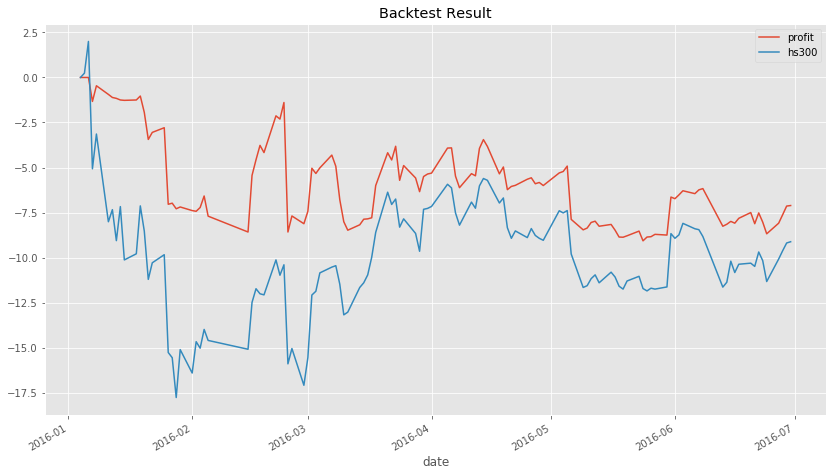

In [37]:
df_profit.plot(title='Backtest Result', y=['profit', 'hs300'], kind='line');

In [20]:
df_profit.index.name = 'date'

In [40]:
# df_profit['net_value']

In [43]:
compute_drawdown(df_profit['net_value'])

0.08999999999999997

In [44]:
cum_net_value = df_profit['net_value'].cumsum()

In [46]:
length = len(cum_net_value)
maxDrawDown = np.zeros(length)
for i in range(length):
    C = cum_net_value[:i].max()
    if C == cum_net_value[i]:
        maxDrawDown[i] = 0
    else:
        maxDrawDown[i] = (C - cum_net_value[i]) / C

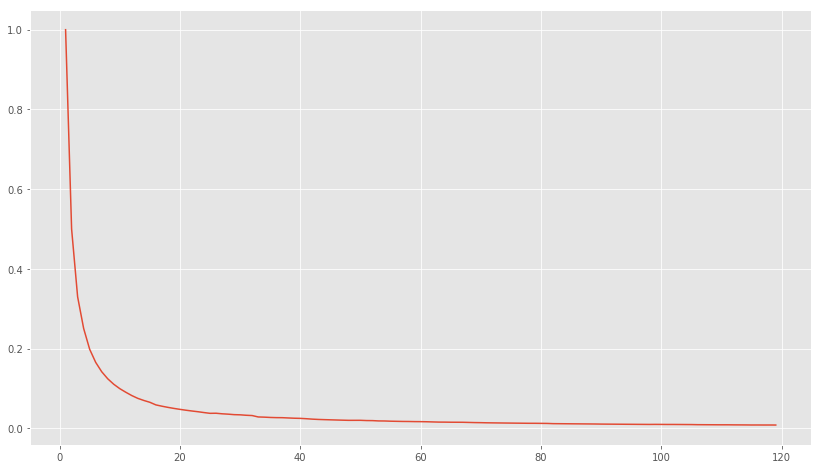

In [50]:
plt.plot(np.abs(maxDrawDown));

In [51]:
net_value = df_profit.net_value
nums = len(net_value)
maxDrawDown = np.zeros(length)
for i in range(nums):
    C = net_value.max()
    if C == net_value[i]:
        maxDrawDown[i] = 0
    else:
        maxDrawDown[i] = (C - net_value[i]) / C

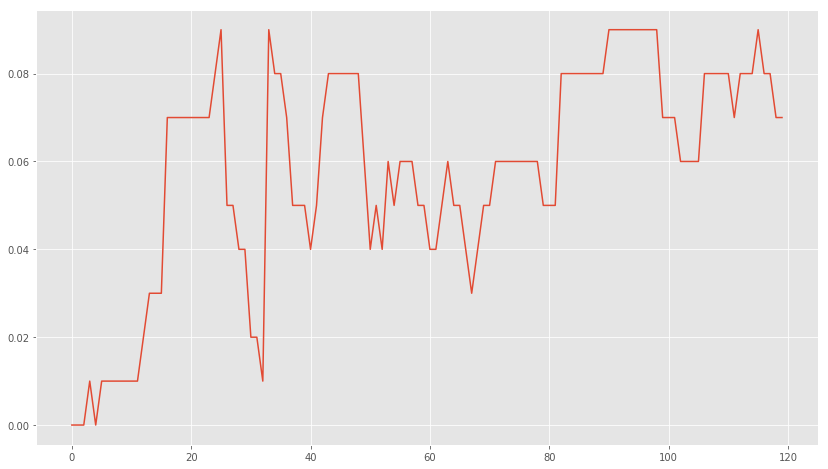

In [52]:
plt.plot(maxDrawDown);

In [53]:
maxDrawDown.max()

0.08999999999999997

In [ ]:
pd.DataFrame()